## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.patches as mpatches
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

pd.set_option('display.max_columns', None)


## Load data

In [2]:
path = '/Users/alexaterrazas/Desktop/Lake Transfer Function Manuscript/'
df = pd.read_csv(path + 'ERA5_LakeTemp.csv')

df

,Hylak_id,center_long,center_lat,Lake_name,Country,Continent,Lake_type,Lake_area,Depth_avg,Elevation,n_obs,stat_method,intermittency,Tyear_mean,Tyear_mean_open,Tyear_min,Tyear_max,Tyear_CImean_min,Tyear_CImean_max,ice_days,ice_days_min,ice_days_max,ice_start,ice_start_min,ice_start_max,ice_end,ice_end_min,ice_end_max,Tmonth_mean_1,Tmonth_mean_2,Tmonth_mean_3,Tmonth_mean_4,Tmonth_mean_5,Tmonth_mean_6,Tmonth_mean_7,Tmonth_mean_8,Tmonth_mean_9,Tmonth_mean_10,Tmonth_mean_11,Tmonth_mean_12,Tmonth_min_1,Tmonth_min_2,Tmonth_min_3,Tmonth_min_4,Tmonth_min_5,Tmonth_min_6,Tmonth_min_7,Tmonth_min_8,Tmonth_min_9,Tmonth_min_10,Tmonth_min_11,Tmonth_min_12,Tmonth_max_1,Tmonth_max_2,Tmonth_max_3,Tmonth_max_4,Tmonth_max_5,Tmonth_max_6,Tmonth_max_7,Tmonth_max_8,Tmonth_max_9,Tmonth_max_10,Tmonth_max_11,Tmonth_max_12,Tmonth_CImean_min_1,Tmonth_CImean_min_2,Tmonth_CImean_min_3,Tmonth_CImean_min_4,Tmonth_CImean_min_5,Tmonth_CImean_min_6,Tmonth_CImean_min_7,Tmonth_CImean_min_8,Tmonth_CImean_min_9,Tmonth_CImean_min_10,Tmonth_CImean_min_11,Tmonth_CImean_min_12,Tmonth_CImean_max_1,Tmonth_CImean_max_2,Tmonth_CImean_max_3,Tmonth_CImean_max_4,Tmonth_CImean_max_5,Tmonth_CImean_max_6,Tmonth_CImean_max_7,Tmonth_CImean_max_8,Tmonth_CImean_max_9,Tmonth_CImean_max_10,Tmonth_CImean_max_11,Tmonth_CImean_max_12,Tmonth_CIpred_min_1,Tmonth_CIpred_min_2,Tmonth_CIpred_min_3,Tmonth_CIpred_min_4,Tmonth_CIpred_min_5,Tmonth_CIpred_min_6,Tmonth_CIpred_min_7,Tmonth_CIpred_min_8,Tmonth_CIpred_min_9,Tmonth_CIpred_min_10,Tmonth_CIpred_min_11,Tmonth_CIpred_min_12,Tmonth_CIpred_max_1,Tmonth_CIpred_max_2,Tmonth_CIpred_max_3,Tmonth_CIpred_max_4,Tmonth_CIpred_max_5,Tmonth_CIpred_max_6,Tmonth_CIpred_max_7,Tmonth_CIpred_max_8,Tmonth_CIpred_max_9,Tmonth_CIpred_max_10,Tmonth_CIpred_max_11,Tmonth_CIpred_max_12,lswt_ann_avg,lswt_ao_avg,lswt_amj_avg,lswt_jja_avg,lswt_warmest_avg,abs_lat,sq_lswt_ann,sq_lswt_ao,sq_lswt_amj,sq_lswt_jja,sq_lswt_warmest,log_lake_area,log_depth,elevation_km,nearest_temp_1,nearest_temp_2,nearest_temp_3,nearest_temp_4,nearest_temp_5,nearest_temp_6,nearest_temp_7,nearest_temp_8,nearest_temp_9,nearest_temp_10,nearest_temp_11,nearest_temp_12,nearest_tcc_1,nearest_tcc_2,nearest_tcc_3,nearest_tcc_4,nearest_tcc_5,nearest_tcc_6,nearest_tcc_7,nearest_tcc_8,nearest_tcc_9,nearest_tcc_10,nearest_tcc_11,nearest_tcc_12,nearest_rh_1,nearest_rh_2,nearest_rh_3,nearest_rh_4,nearest_rh_5,nearest_rh_6,nearest_rh_7,nearest_rh_8,nearest_rh_9,nearest_rh_10,nearest_rh_11,nearest_rh_12,nearest_ssr_1,nearest_ssr_2,nearest_ssr_3,nearest_ssr_4,nearest_ssr_5,nearest_ssr_6,nearest_ssr_7,nearest_ssr_8,nearest_ssr_9,nearest_ssr_10,nearest_ssr_11,nearest_ssr_12,nearest_u10_1,nearest_u10_2,nearest_u10_3,nearest_u10_4,nearest_u10_5,nearest_u10_6,nearest_u10_7,nearest_u10_8,nearest_u10_9,nearest_u10_10,nearest_u10_11,nearest_u10_12,tas_ann_avg,tas_ao_avg,tas_amj_avg,tas_jja_avg,tas_warmest_month,tcc_ann_avg,rh_ann_avg,ssr_ann_avg,u10_ann_avg
0,2,-120.798314,66.045499,Great Bear,Canada,North America,1,30450.640630,72.199997,145,157,0.0,0.0,97.0,272.0,0.0,463.0,73.0,125.0,235.0,191.0,337.0,294.0,312.0,258.0,163.0,137.0,229.0,0.0,0.0,0.0,0.0,0.0,40.0,192.0,375.0,430.0,119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0,280.0,339.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,273.0,453.0,463.0,327.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,138.0,317.0,346.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,247.0,433.0,513.0,195.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,382.0,543.0,759.0,869.0,518.0,24.0,0.0,0.963333,1.651429,0.133333,2.023333,4.30,66.045499,0.928011,2.727216,0.017778,4.093878,18.4900,10.323862,4.279440,0.145,-25.360504,-25.885590,-19.531387,-10.493896,-1.000793,2.721466,6.824036,10.075806,7.790649,1.848053,-8.333740,-21.647293,66.647730,68.721820,65.023270,62.227560,60.025450,60.191450,61.893723,64.689255,75.691660,86.023670,91.031820,75.768650,87.322980,82.130610,78.237530,78.935326,89.420250,91.41833,91.081210,85.996210,75.542190,73.726616,78.115750,85.278910,117824.22,861198.0,2

In [3]:
def repeated_cv_TF1(season):
    # Define the features
    features = [season]
    target = 'tas_ann_avg'

    # Prepare the data
    X = df[features]
    y = df[target]

    # Initialize the model
    model = LinearRegression()

    # Perform repeated 10-fold cross-validation to get predictions and calculate residuals
    repeated_kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    
    test_rmse_list = []
    test_r2_list = []

    y_cv_pred = np.zeros_like(y)

    for train_idx, test_idx in repeated_kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Predict on both training and testing sets
        y_test_pred = model.predict(X_test)

        # Store the cross-validated predictions for later residuals calculation
        y_cv_pred[test_idx] = y_test_pred

        # Calculate test RMSE and R^2
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)

        # Append the results to the respective lists
        test_rmse_list.append(test_rmse)
        test_r2_list.append(test_r2)

    # Calculate average and standard deviation of metrics across all folds
    avg_test_rmse = np.mean(test_rmse_list)
    std_test_rmse = np.std(test_rmse_list)
    avg_test_r2 = np.mean(test_r2_list)
    std_test_r2 = np.std(test_r2_list)

    # Calculate residuals for the entire cross-validated dataset
    residuals = y - y_cv_pred

    # Calculate AIC using statsmodels (using entire dataset for fitting)
    X_with_const = sm.add_constant(X)
    model_sm = sm.OLS(y, X_with_const).fit()
    aic = model_sm.aic

    # Return the requested statistics
    return test_rmse_list, test_r2_list, aic


In [4]:
def repeated_cv_TF2(season):
    
    # Define the features
    df['Tw squared'] = np.power(df[season], 2)
    features = [season, 'Tw squared']
    target = 'tas_ann_avg'
   
    # Prepare the data
    X = df[features]
    y = df[target]

    # Initialize the model
    model = LinearRegression()

    # Perform repeated 10-fold cross-validation to get predictions and calculate residuals
    repeated_kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    
    test_rmse_list = []
    test_r2_list = []

    y_cv_pred = np.zeros_like(y)

    for train_idx, test_idx in repeated_kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Predict on the testing set
        y_test_pred = model.predict(X_test)

        # Store the cross-validated predictions for later residuals calculation
        y_cv_pred[test_idx] = y_test_pred

        # Calculate test RMSE and R^2
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)

        # Append the results to the respective lists
        test_rmse_list.append(test_rmse)
        test_r2_list.append(test_r2)

    # Calculate average and standard deviation of metrics across all folds
    avg_test_rmse = np.mean(test_rmse_list)
    std_test_rmse = np.std(test_rmse_list)
    avg_test_r2 = np.mean(test_r2_list)
    std_test_r2 = np.std(test_r2_list)

    # Calculate residuals for the entire cross-validated dataset
    residuals = y - y_cv_pred

    # Calculate AIC using statsmodels (using entire dataset for fitting)
    X_with_const = sm.add_constant(X)
    model_sm = sm.OLS(y, X_with_const).fit()
    aic = model_sm.aic

    # Return the requested statistics
    return test_rmse_list, test_r2_list, aic


In [5]:
def repeated_cv_TF3(season):
    # Define the features
    df['Tw squared'] = np.power(df[season], 2)
    features = [season, 'Tw squared', 'abs_lat']
    target = 'tas_ann_avg'

    # Prepare the data
    X = df[features]
    y = df[target]

    # Initialize the model
    model = LinearRegression()

    # Perform repeated 10-fold cross-validation
    repeated_kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    test_rmse_list = []
    test_r2_list = []

    y_cv_pred = np.zeros_like(y)

    for train_idx, test_idx in repeated_kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Predict on the testing set
        y_test_pred = model.predict(X_test)

        # Store the cross-validated predictions for later residuals calculation
        y_cv_pred[test_idx] = y_test_pred

        # Calculate test RMSE and R^2
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)

        # Append the results to the respective lists
        test_rmse_list.append(test_rmse)
        test_r2_list.append(test_r2)

    # Calculate average and standard deviation of metrics across all folds
    avg_test_rmse = np.mean(test_rmse_list)
    std_test_rmse = np.std(test_rmse_list)
    avg_test_r2 = np.mean(test_r2_list)
    std_test_r2 = np.std(test_r2_list)

    # Calculate residuals for the entire cross-validated dataset
    residuals = y - y_cv_pred

    # Calculate AIC using statsmodels (using the entire dataset for fitting)
    X_with_const = sm.add_constant(X)
    model_sm = sm.OLS(y, X_with_const).fit()
    aic = model_sm.aic

    # Return the requested statistics
    return test_rmse_list, test_r2_list, aic

In [6]:
def repeated_cv_TF4(season):
    # Define the features
    df['Tw squared'] = np.power(df[season], 2)
    features = [season, 'Tw squared', 'abs_lat', 'elevation_km']
    target = 'tas_ann_avg'

    # Prepare the data
    X = df[features]
    y = df[target]

    # Initialize the model
    model = LinearRegression()

    # Perform repeated 10-fold cross-validation
    repeated_kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    test_rmse_list = []
    test_r2_list = []

    y_cv_pred = np.zeros_like(y)

    for train_idx, test_idx in repeated_kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Predict on the testing set
        y_test_pred = model.predict(X_test)

        # Store the cross-validated predictions for later residuals calculation
        y_cv_pred[test_idx] = y_test_pred

        # Calculate test RMSE and R^2
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)

        # Append the results to the respective lists
        test_rmse_list.append(test_rmse)
        test_r2_list.append(test_r2)

    # Calculate average and standard deviation of metrics across all folds
    avg_test_rmse = np.mean(test_rmse_list)
    std_test_rmse = np.std(test_rmse_list)
    avg_test_r2 = np.mean(test_r2_list)
    std_test_r2 = np.std(test_r2_list)

    # Calculate residuals for the entire cross-validated dataset
    residuals = y - y_cv_pred

    # Calculate AIC using statsmodels (using the entire dataset for fitting)
    X_with_const = sm.add_constant(X)
    model_sm = sm.OLS(y, X_with_const).fit()
    aic = model_sm.aic

    # Return the requested statistics
    return test_rmse_list, test_r2_list, aic

## Hren and Sheldon 

In [7]:
# Custom function where x is 'lswt_ann_avg'
def hs_annual(x):
    return (-0.0318) * np.power(x, 2) + (2.195 * x) - 12.607

def residuals_HS_model_ann():
    # Prepare the data
    x = df['lswt_ann_avg']
    y = df['tas_ann_avg']

    # Initialize the cross-validation procedure
    repeated_kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    # Arrays to store predictions, R² scores, and RMSE scores for cross-validation
    y_cv_pred = np.zeros_like(y)
    cv_r2_scores = []
    cv_rmse_scores = []

    # Perform repeated 10-fold cross-validation
    for train_idx, test_idx in repeated_kf.split(x):
        # Training and testing sets for this fold
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Predict y using the custom function on the test set
        y_pred_test = hs_annual(x_test)

        # Store the predictions for residuals calculation
        y_cv_pred[test_idx] = y_pred_test

        # Calculate R² and RMSE for this fold
        r2 = r2_score(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

        # Append the fold's metrics to the lists
        cv_r2_scores.append(r2)
        cv_rmse_scores.append(rmse)

    # Calculate the average R² and RMSE across all cross-validation folds
    avg_test_r2 = np.mean(cv_r2_scores)
    avg_test_rmse = np.mean(cv_rmse_scores)

    # Calculate the standard deviation of R² and RMSE across all cross-validation folds
    std_test_r2 = np.std(cv_r2_scores)
    std_test_rmse = np.std(cv_rmse_scores)

    # Calculate residuals for the entire cross-validated dataset
    residuals = y - y_cv_pred

    # Calculate AIC using statsmodels
    # Since we're using a custom function, we'll fit an OLS model to the residuals
    X_with_const = sm.add_constant(x)
    model_sm = sm.OLS(y_cv_pred, X_with_const).fit()
    aic = model_sm.aic

    # Print the cross-validation results
    print(f"Average Test RMSE from CV: {avg_test_rmse:.4f} ± {std_test_rmse:.4f}")
    print(f"Average Test R² from CV: {avg_test_r2:.4f} ± {std_test_r2:.4f}")
    print(f"AIC: {aic:.4f}")

    return cv_rmse_scores, cv_r2_scores, aic

In [8]:
# Custom function where x is 'lswt_ao_avg'
def hs_AO(x):
    return (-0.0146) * np.power(x, 2) + (1.753 * x) - 16.079

def residuals_HS_model_AO():
    # Prepare the data
    x = df['lswt_ao_avg']
    y = df['tas_ann_avg']

    # Initialize the cross-validation procedure
    repeated_kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    # Arrays to store predictions, R² scores, and RMSE scores for cross-validation
    y_cv_pred = np.zeros_like(y)
    cv_r2_scores = []
    cv_rmse_scores = []

    # Perform repeated 10-fold cross-validation
    for train_idx, test_idx in repeated_kf.split(x):
        # Training and testing sets for this fold
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Predict y using the custom function on the test set
        y_pred_test = hs_AO(x_test)

        # Store the predictions for residuals calculation
        y_cv_pred[test_idx] = y_pred_test

        # Calculate R² and RMSE for this fold
        r2 = r2_score(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

        # Append the fold's metrics to the lists
        cv_r2_scores.append(r2)
        cv_rmse_scores.append(rmse)

    # Calculate the average R² and RMSE across all cross-validation folds
    avg_test_r2 = np.mean(cv_r2_scores)
    avg_test_rmse = np.mean(cv_rmse_scores)

    # Calculate the standard deviation of R² and RMSE across all cross-validation folds
    std_test_r2 = np.std(cv_r2_scores)
    std_test_rmse = np.std(cv_rmse_scores)

    # Calculate residuals for the entire cross-validated dataset
    residuals = y - y_cv_pred

    # Calculate AIC using statsmodels
    # Since we're using a custom function, we'll fit an OLS model to the residuals
    X_with_const = sm.add_constant(x)
    model_sm = sm.OLS(y_cv_pred, X_with_const).fit()
    aic = model_sm.aic

    # Print the cross-validation results
    print(f"Average Test RMSE from CV: {avg_test_rmse:.4f} ± {std_test_rmse:.4f}")
    print(f"Average Test R² from CV: {avg_test_r2:.4f} ± {std_test_r2:.4f}")
    print(f"AIC: {aic:.4f}")

    return cv_rmse_scores, cv_r2_scores, aic

In [9]:
# Custom function where x is 'lswt_amj_avg'
def hs_AMJ(x):
    return (-0.0097) * np.power(x, 2) + (1.379 * x) - 8.227

def residuals_HS_model_AMJ():
    # Prepare the data
    x = df['lswt_amj_avg']
    y = df['tas_ann_avg']

    # Initialize the cross-validation procedure
    repeated_kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    # Arrays to store predictions, R² scores, and RMSE scores for cross-validation
    y_cv_pred = np.zeros_like(y)
    cv_r2_scores = []
    cv_rmse_scores = []

    # Perform repeated 10-fold cross-validation
    for train_idx, test_idx in repeated_kf.split(x):
        # Training and testing sets for this fold
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Predict y using the custom function on the test set
        y_pred_test = hs_AMJ(x_test)

        # Store the predictions for residuals calculation
        y_cv_pred[test_idx] = y_pred_test

        # Calculate R² and RMSE for this fold
        r2 = r2_score(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

        # Append the fold's metrics to the lists
        cv_r2_scores.append(r2)
        cv_rmse_scores.append(rmse)

    # Calculate the average R² and RMSE across all cross-validation folds
    avg_test_r2 = np.mean(cv_r2_scores)
    avg_test_rmse = np.mean(cv_rmse_scores)

    # Calculate the standard deviation of R² and RMSE across all cross-validation folds
    std_test_r2 = np.std(cv_r2_scores)
    std_test_rmse = np.std(cv_rmse_scores)

    # Calculate residuals for the entire cross-validated dataset
    residuals = y - y_cv_pred

    # Calculate AIC using statsmodels
    # Since we're using a custom function, we'll fit an OLS model to the residuals
    X_with_const = sm.add_constant(x)
    model_sm = sm.OLS(y_cv_pred, X_with_const).fit()
    aic = model_sm.aic

    # Print the cross-validation results
    print(f"Average Test RMSE from CV: {avg_test_rmse:.4f} ± {std_test_rmse:.4f}")
    print(f"Average Test R² from CV: {avg_test_r2:.4f} ± {std_test_r2:.4f}")
    print(f"AIC: {aic:.4f}")

    return cv_rmse_scores, cv_r2_scores, aic

In [10]:
# Custom function where x is 'lswt_jja_avg'
def hs_JJA(x):
    return (-0.0055) * np.power(x, 2) + (1.476 * x) - 18.915

def residuals_HS_model_JJA():
    # Prepare the data
    x = df['lswt_jja_avg']
    y = df['tas_ann_avg']

    # Initialize the cross-validation procedure
    repeated_kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    # Arrays to store predictions, R² scores, and RMSE scores for cross-validation
    y_cv_pred = np.zeros_like(y)
    cv_r2_scores = []
    cv_rmse_scores = []

    # Perform repeated 10-fold cross-validation
    for train_idx, test_idx in repeated_kf.split(x):
        # Training and testing sets for this fold
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Predict y using the custom function on the test set
        y_pred_test = hs_JJA(x_test)

        # Store the predictions for residuals calculation
        y_cv_pred[test_idx] = y_pred_test

        # Calculate R² and RMSE for this fold
        r2 = r2_score(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

        # Append the fold's metrics to the lists
        cv_r2_scores.append(r2)
        cv_rmse_scores.append(rmse)

    # Calculate the average R² and RMSE across all cross-validation folds
    avg_test_r2 = np.mean(cv_r2_scores)
    avg_test_rmse = np.mean(cv_rmse_scores)

    # Calculate the standard deviation of R² and RMSE across all cross-validation folds
    std_test_r2 = np.std(cv_r2_scores)
    std_test_rmse = np.std(cv_rmse_scores)

    # Calculate residuals for the entire cross-validated dataset
    residuals = y - y_cv_pred

    # Calculate AIC using statsmodels
    # Since we're using a custom function, we'll fit an OLS model to the residuals
    X_with_const = sm.add_constant(x)
    model_sm = sm.OLS(y_cv_pred, X_with_const).fit()
    aic = model_sm.aic

    # Print the cross-validation results
    print(f"Average Test RMSE from CV: {avg_test_rmse:.4f} ± {std_test_rmse:.4f}")
    print(f"Average Test R² from CV: {avg_test_r2:.4f} ± {std_test_r2:.4f}")
    print(f"AIC: {aic:.4f}")

    return cv_rmse_scores, cv_r2_scores, aic

In [11]:
def hs_Warmest(x):
    return (x/0.562) - (17.3/0.562)

def residuals_HS_model_Warmest():
    # Prepare the data
    x = df['lswt_warmest_avg']
    y = df['tas_ann_avg']

    # Initialize the cross-validation procedure
    repeated_kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    # Arrays to store predictions, R² scores, and RMSE scores for cross-validation
    y_cv_pred = np.zeros_like(y)
    cv_r2_scores = []
    cv_rmse_scores = []

    # Perform repeated 10-fold cross-validation
    for train_idx, test_idx in repeated_kf.split(x):
        # Training and testing sets for this fold
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Predict y using the custom function on the test set
        y_pred_test = hs_JJA(x_test)

        # Store the predictions for residuals calculation
        y_cv_pred[test_idx] = y_pred_test

        # Calculate R² and RMSE for this fold
        r2 = r2_score(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

        # Append the fold's metrics to the lists
        cv_r2_scores.append(r2)
        cv_rmse_scores.append(rmse)

    # Calculate the average R² and RMSE across all cross-validation folds
    avg_test_r2 = np.mean(cv_r2_scores)
    avg_test_rmse = np.mean(cv_rmse_scores)

    # Calculate the standard deviation of R² and RMSE across all cross-validation folds
    std_test_r2 = np.std(cv_r2_scores)
    std_test_rmse = np.std(cv_rmse_scores)

    # Calculate residuals for the entire cross-validated dataset
    residuals = y - y_cv_pred

    # Calculate AIC using statsmodels
    # Since we're using a custom function, we'll fit an OLS model to the residuals
    X_with_const = sm.add_constant(x)
    model_sm = sm.OLS(y_cv_pred, X_with_const).fit()
    aic = model_sm.aic

    # Print the cross-validation results
    print(f"Average Test RMSE from CV: {avg_test_rmse:.4f} ± {std_test_rmse:.4f}")
    print(f"Average Test R² from CV: {avg_test_r2:.4f} ± {std_test_r2:.4f}")
    print(f"AIC: {aic:.4f}")

    return cv_rmse_scores, cv_r2_scores, aic

In [12]:
# Function to add the legend
def legend_plots():
    blue = plt.cm.tab10(0)
    orange = plt.cm.tab10(1)
    red =  '#CC3311'
    green =  '#009988'
    gray = 'gray'

    
    # Define the rectangles for the legend
    tf1 = mpatches.Rectangle((0, 0), 1, 1, facecolor=blue, edgecolor="black", label='TF1')
    tf2 = mpatches.Rectangle((0, 0), 1, 1, facecolor=orange, edgecolor="black", label='TF2')
    tf3 = mpatches.Rectangle((0, 0), 1, 1, facecolor=red, edgecolor="black", label='TF3')
    tf4 = mpatches.Rectangle((0, 0), 1, 1, facecolor=green, edgecolor="black", label='TF4')
    hs = mpatches.Rectangle((0, 0), 1, 1, facecolor=gray, edgecolor="black", label='HS')

    # Create the legend
    axes[0, 0].legend(handles=[tf1, tf2, tf3, tf4, hs], 
                    labels=['Transfer Function 1', 'Transfer Function 2', 'Transfer Function 3', 'Transfer Function 4', 'Hren and Sheldon (2012)'],
                    loc='upper right', frameon=True, fontsize=41)

    return

Average Test RMSE from CV: 2.4218 ± 0.1682
Average Test R² from CV: 0.9526 ± 0.0065
AIC: 5592.3878
Average Test RMSE from CV: 2.4218 ± 0.1682
Average Test R² from CV: 0.9526 ± 0.0065
AIC: 5592.3878


/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Average Test RMSE from CV: 2.9601 ± 0.2578
Average Test R² from CV: 0.9291 ± 0.0117
AIC: 4036.5895
Average Test RMSE from CV: 2.9601 ± 0.2578
Average Test R² from CV: 0.9291 ± 0.0117
AIC: 4036.5895


/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Average Test RMSE from CV: 3.0797 ± 0.2202
Average Test R² from CV: 0.9234 ± 0.0100
AIC: 3597.6434
Average Test RMSE from CV: 3.0797 ± 0.2202
Average Test R² from CV: 0.9234 ± 0.0100
AIC: 3597.6434


/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Average Test RMSE from CV: 5.1528 ± 0.3418
Average Test R² from CV: 0.7853 ± 0.0295
AIC: 1720.1473
Average Test RMSE from CV: 5.1528 ± 0.3418
Average Test R² from CV: 0.7853 ± 0.0295
AIC: 1720.1473


/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Average Test RMSE from CV: 6.9566 ± 0.3254
Average Test R² from CV: 0.6081 ± 0.0511
AIC: 1522.9422
Average Test RMSE from CV: 6.9566 ± 0.3254
Average Test R² from CV: 0.6081 ± 0.0511
AIC: 1522.9422


/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


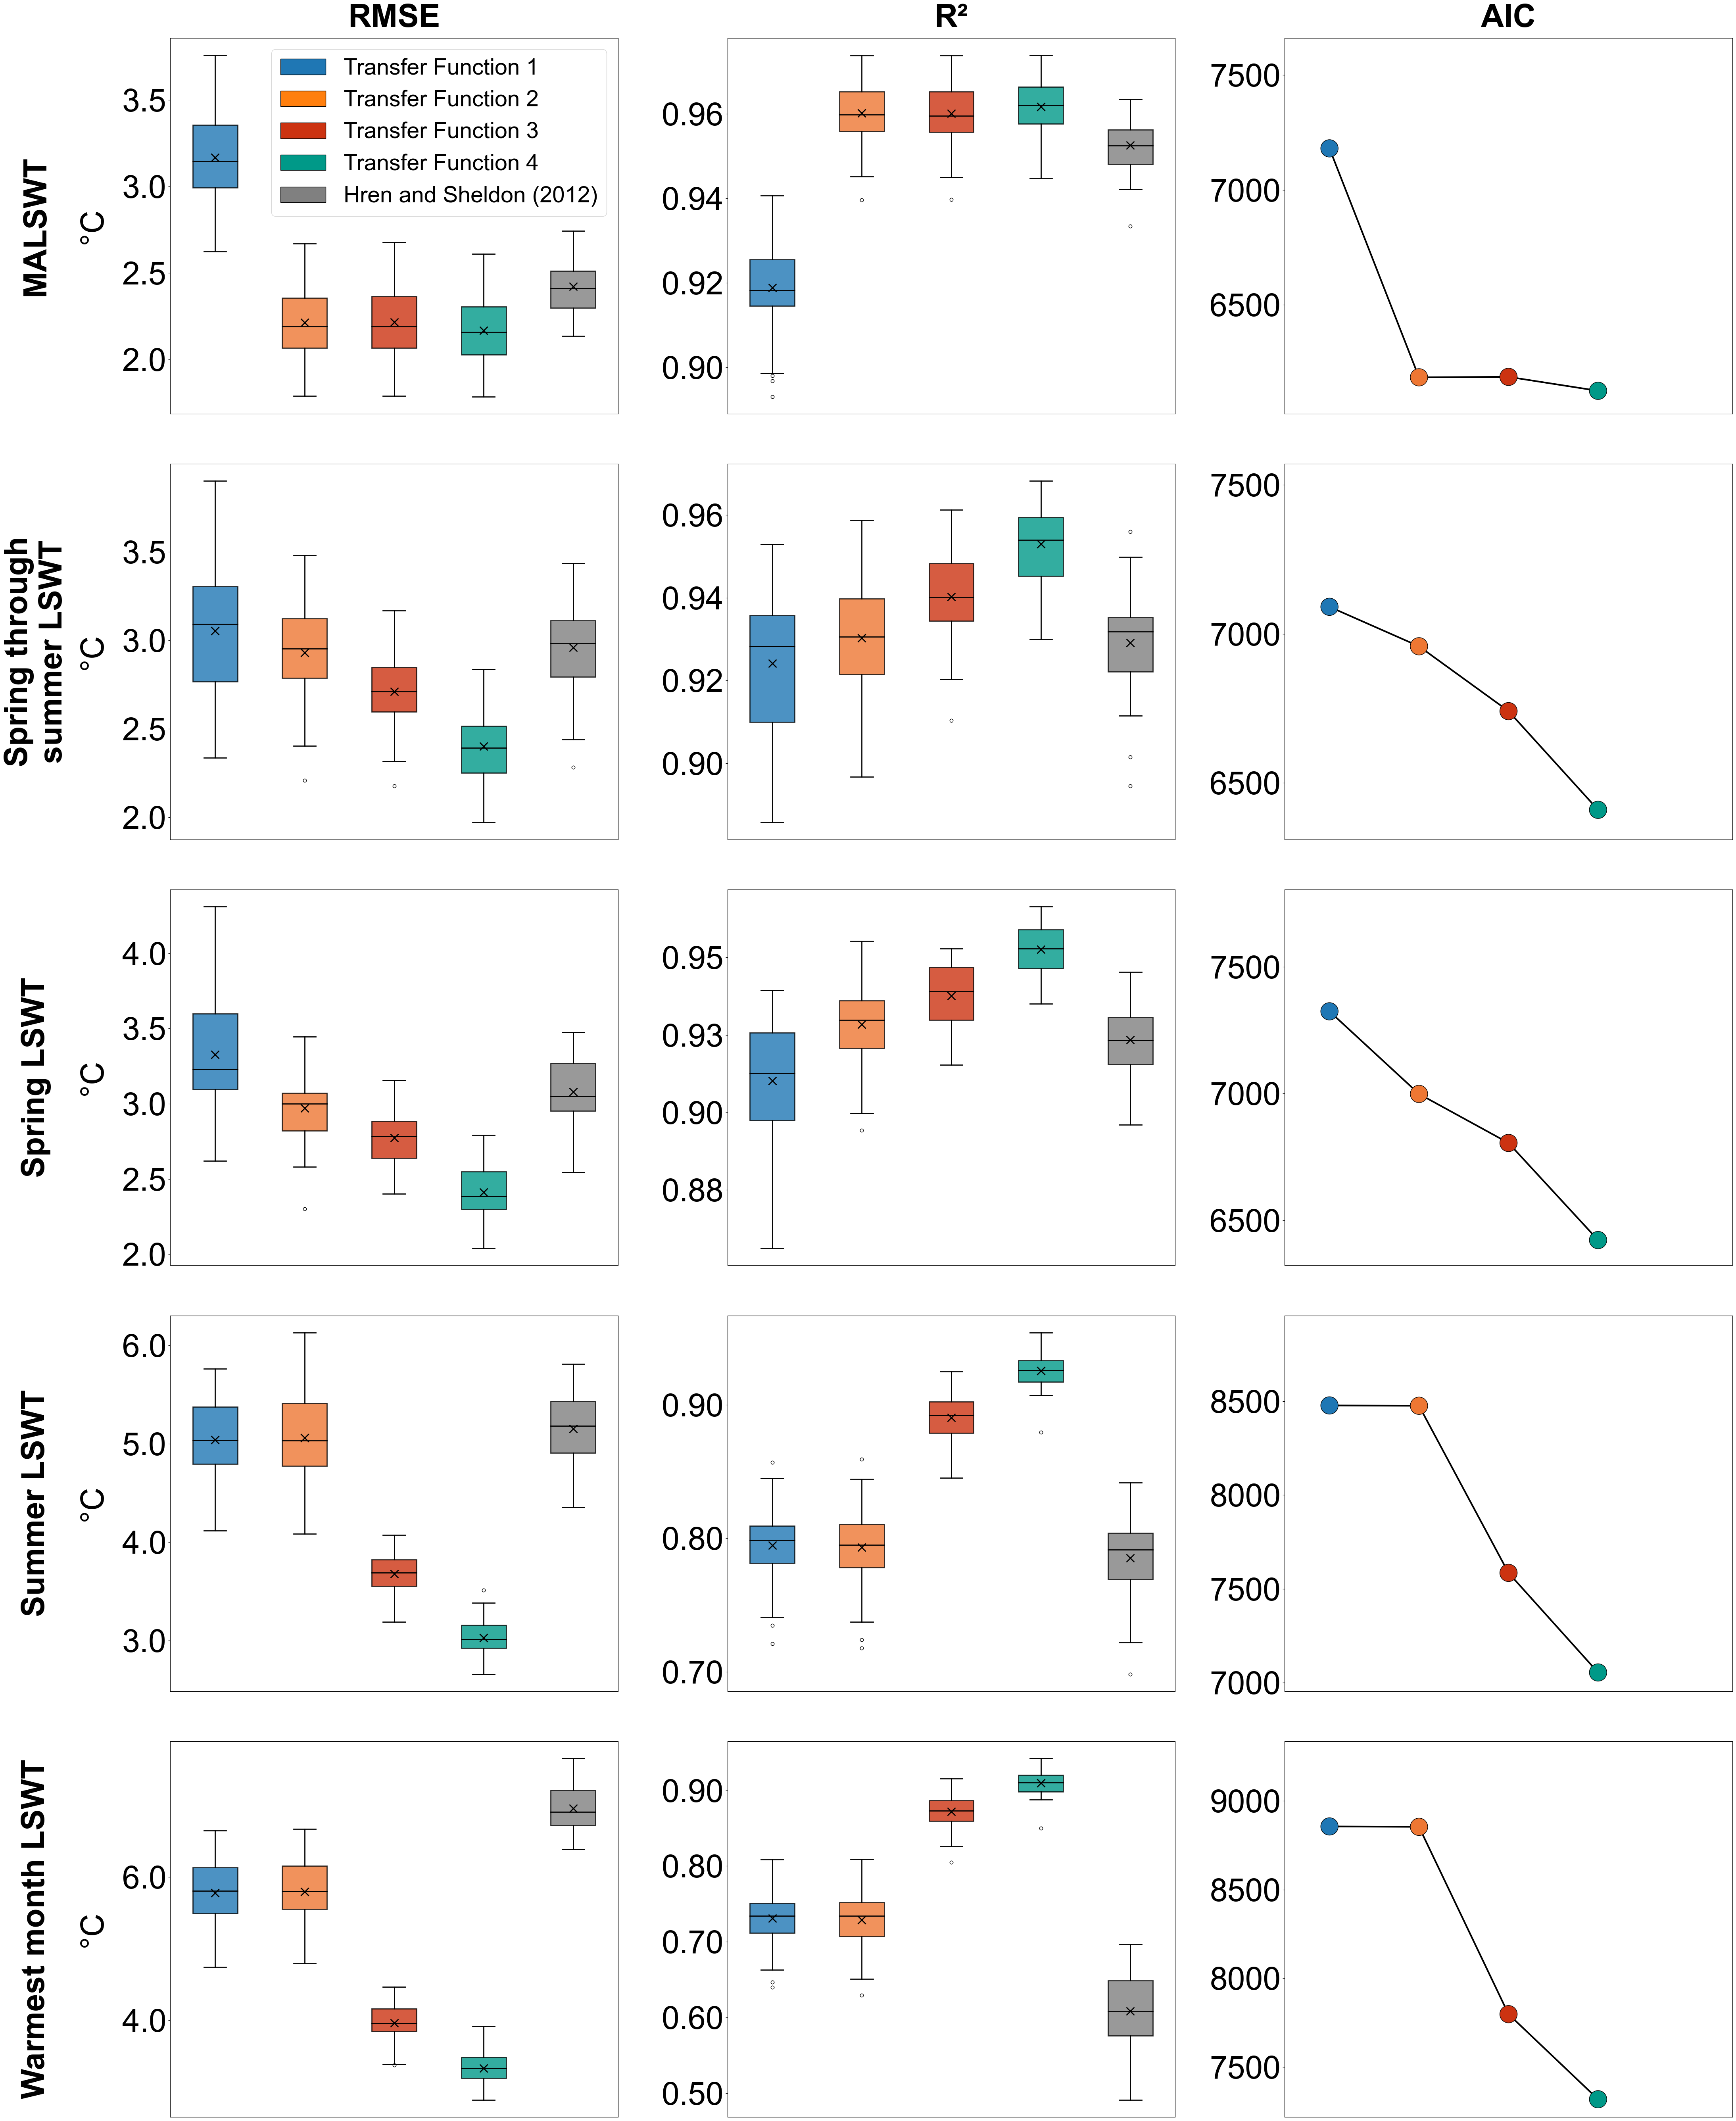

In [15]:
import matplotlib.ticker as mticker

# Define a function to format ticks to 2 decimal places for RMSE
def format_rmse_ticks(ax):
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# Define a function to format ticks to 3 decimal places for R²
def format_r2_ticks(ax):
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Set global font settings
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 58

# Example seasons (replace with actual season variables)
seasons = ['lswt_ann_avg', 'lswt_ao_avg', 'lswt_amj_avg', 'lswt_jja_avg', 'lswt_warmest_avg']
titles = ['MALSWT', 'Spring through\nsummer LSWT', 'Spring LSWT', 'Summer LSWT', 'Warmest month LSWT']

# Prepare the figure with 5 rows (for seasons) and 3 columns (for RMSE, R², and AIC)
fig, axes = plt.subplots(len(seasons), 3, figsize=(45, 55), 
                         gridspec_kw={'width_ratios': [1, 1, 1]}, 
                         sharex=True)  # 5 rows, 3 columns

for i, (season, title) in enumerate(zip(seasons, titles)):
    # Determine the correct HS_Model based on the season
    if season == 'lswt_ann_avg':
        rmse_hs = residuals_HS_model_ann()[0]
        r2_hs = residuals_HS_model_ann()[1]
        aic_hs = None  # Assuming no AIC for HS_Model
    elif season == 'lswt_ao_avg':
        rmse_hs = residuals_HS_model_AO()[0]
        r2_hs = residuals_HS_model_AO()[1]
        aic_hs = None
    elif season == 'lswt_amj_avg':
        rmse_hs = residuals_HS_model_AMJ()[0]
        r2_hs = residuals_HS_model_AMJ()[1]
        aic_hs = None
    elif season == 'lswt_jja_avg':
        rmse_hs = residuals_HS_model_JJA()[0]
        r2_hs = residuals_HS_model_JJA()[1]
        aic_hs = None
    elif season == 'lswt_warmest_avg':
        rmse_hs = residuals_HS_model_Warmest()[0]
        r2_hs = residuals_HS_model_Warmest()[1]
        aic_hs = None

    # Prepare the data for each model
    data_rmse = [
        repeated_cv_TF1(season)[0], 
        repeated_cv_TF2(season)[0], 
        repeated_cv_TF3(season)[0], 
        repeated_cv_TF4(season)[0],
        rmse_hs
    ]

    # Plot RMSE in the first column
    boxplot = axes[i, 0].boxplot(data_rmse, patch_artist=True)
    
    # Set colors and linewidths for each boxplot element
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_linewidth(2)  # Set box linewidth
        patch.set_alpha(0.8)
    
    plt.setp(boxplot['whiskers'], color='black', linewidth=2)
    plt.setp(boxplot['caps'], color='black', linewidth=2)
    plt.setp(boxplot['medians'], color='black', linewidth=2)
    
    # Add an "X" marker at the mean of each boxplot
    for j in range(len(data_rmse)):
        mean = np.mean(data_rmse[j])
        axes[i, 0].plot(j + 1, mean, 'x', color='black', markersize=15, markeredgewidth=2, zorder=4)  # Larger and thicker X marker

    # Apply RMSE tick formatting to 2 decimal places
    format_rmse_ticks(axes[i, 0])
    
    # Plot R² in the second column
    data_r2 = [
        repeated_cv_TF1(season)[1], 
        repeated_cv_TF2(season)[1], 
        repeated_cv_TF3(season)[1], 
        repeated_cv_TF4(season)[1],
        r2_hs
    ]
    
    boxplot = axes[i, 1].boxplot(data_r2, patch_artist=True)
    
    # Set colors and linewidths for each boxplot element
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_linewidth(2)
        patch.set_alpha(0.8)
    
    plt.setp(boxplot['whiskers'], color='black', linewidth=2)
    plt.setp(boxplot['caps'], color='black', linewidth=2)
    plt.setp(boxplot['medians'], color='black', linewidth=2)
    
    # Add an "X" marker at the mean of each boxplot
    for j in range(len(data_r2)):
        mean = np.mean(data_r2[j])
        axes[i, 1].plot(j + 1, mean, 'x', color='black', markersize=15, markeredgewidth=2, zorder=4)
    
    # Apply R² tick formatting to 3 decimal places
    format_r2_ticks(axes[i, 1])

    # Plot AIC in the third column as scatter points
    aic_values = [repeated_cv_TF1(season)[2], 
                  repeated_cv_TF2(season)[2], 
                  repeated_cv_TF3(season)[2], 
                  repeated_cv_TF4(season)[2],
                  aic_hs]  # HS_Model AIC (if applicable)
    
    # Handle the case where HS_Model has no AIC (e.g., set to None or NaN)
    if aic_hs is None:
        aic_values[-1] = float('nan')  # Set HS_Model AIC to NaN if not available

    axes[i, 2].scatter(range(1, len(aic_values) + 1), aic_values, c=colors, edgecolor='k', s=1000, zorder=2)
    axes[i, 2].plot(range(1, len(aic_values) + 1), aic_values, c='k', marker='', linewidth=3, zorder=1)

    # Remove x-axis labels and ticks
    axes[i, 2].set_xticks([])
    axes[i, 2].set_xticklabels([])

    # Set the y-axis limits for AIC to ensure it displays all values
    axes[i, 2].set_ylim(bottom=min(aic_values) - 100, top=max(aic_values) + 480)

    # Adding custom y-labels
    axes[i, 0].text(-0.3, 0.5, title, fontsize=58, fontweight='bold', ha='center', va='center', rotation='vertical', transform=axes[i, 0].transAxes)

# Set titles for the columns
axes[0, 0].set_title('RMSE', fontsize=58, fontweight='bold', pad=20)
axes[0, 1].set_title('R²', fontsize=58, fontweight='bold', pad=20)
axes[0, 2].set_title('AIC', fontsize=58, fontweight='bold', pad=20)

# Set y-axis labels for each row
axes[0, 0].set_ylabel('°C', labelpad=25)
axes[1, 0].set_ylabel('°C', labelpad=25)
axes[2, 0].set_ylabel('°C', labelpad=25)
axes[3, 0].set_ylabel('°C', labelpad=25)
axes[4, 0].set_ylabel('°C', labelpad=25)

legend_plots()
plt.subplots_adjust(hspace=-0.5)

# Adjust layout
plt.tight_layout()
plt.savefig('TF_stats.png', dpi=300)

plt.show()
